In [15]:
import pandas as pd
import numpy as np

In [16]:
# Parameters
hash_function = "murmur2"

baseline_recommendations_path = "../data/baseline_recommendations.json"
single_partition_recommendations_path = "../data/single_recommendations.json"
recommendations_path = f"../data/{hash_function}_recommendations.json"
merge_recommendations_path = f"../data/{hash_function}_merge_recommendations.json"
best_partition_recommendations_path = f"../data/{hash_function}_best_partition_recommendations.json"
highest_degree_recommendations_path = f"../data/{hash_function}_highest_degree_recommendations.json"

show_partitions = True
show_merge_1 = True
show_merge_2 = True
show_merge_3 = True

users = "../data/users.json"
output_map = f"../data/{hash_function}_map@k.json"
output_diagram = f"../output/{hash_function}_map@k.png"
output_map_at_k = f"../output/{hash_function}_map@k.csv"

In [17]:
# Read data
baseline_df = pd.read_json(baseline_recommendations_path, orient="table")
single_partition_recommendations_df = pd.read_json(single_partition_recommendations_path, orient="table")

merge_recommendations_df = pd.read_json(merge_recommendations_path, orient="table")
partitioned_recommendations_df = pd.read_json(recommendations_path, orient="table")
partitioned_recommendations_df["len_recommendations"] = partitioned_recommendations_df["recommendations"].str.len()
best_partition_recommendations_df = pd.read_json(best_partition_recommendations_path, orient="table")
highest_degree_recommendations_df = pd.read_json(highest_degree_recommendations_path, orient="table")

user_ids = pd.read_json(users, orient="table")["user_id"].values

In [18]:
def apk(actual: list, predicted: list, k=10) -> float:
    """
    Computes the average precision at k.
    This function computes the average precision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted
    predicted : list
             A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : float
            The average precision at k over the input lists
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    sum_precision = 0.0
    num_hits = 0.0

    for i, prediction in enumerate(predicted):
        if prediction in actual and prediction not in predicted[:i]:
            num_hits += 1.0
            precision_at_i = num_hits / (i + 1.0)
            sum_precision += precision_at_i

    if num_hits == 0.0:
        return 0.0

    return sum_precision / min(len(actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average precision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [24]:
import rbo

a1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# p1 = [10, 6, 9, 7, 8, 3, 2, 5, 4, 1]
p1 = [1, 20,30,40,50,60,70,80,90,100]
print(f"AP@10={apk(a1, p1, 10)}")
print(f"RBO={rbo.RankingSimilarity(a1, p1).rbo(p=0.9)}")

# a2 = [1, 2, 3]
# p2 = [0, 1, 4, 5, 2, 6, 3, 7, 8, 9]
# print(apk(a2, p2, 10))
#
# print(mapk([a1, a2], [p1, p2]))
#
#
# print(f"RBO between a2 and p2: {rbo.RankingSimilarity(a2, p2).rbo()}")

AP@10=1.0
RBO=0.23541639942571424


In [20]:
def calculate_map_k(df):
    list_actual = []
    list_prediction = []
    rows = []

    hash_fun = df["hash_function"].unique()[0]
    partitions = df["partition"].unique()
    partitions.sort()

    for partition in list(partitions):
        for k in range(1, 11):
            for _, uid in enumerate(user_ids):
                actual = baseline_df[baseline_df["user"] == uid]["recommendations"].values[0]

                con = (
                        (df["user"] == uid) &
                        (df["partition"] == partition)
                )

                try:
                    predicted = df[con]["recommendations"].values[0]

                    list_actual.append(actual)
                    list_prediction.append(predicted)
                except IndexError as error:
                    print(f"userID {uid}, partition {partition}, hash_function {hash_fun}")
                    exit(1)

            m = mapk(list_actual, list_prediction, int(k))
            rows.append((hash_fun, partition, k, m))

            print(f"map@{k}: {m}    partition: {partition}    hash_function: {hash_fun}")

    return pd.DataFrame(rows, columns=["hash_function", "partition", "k", "map"])

In [21]:
# Calculate MAP@K for Single, Multi partition, and merged
all_mapk_data_frames = []

mapk_single_df = calculate_map_k(single_partition_recommendations_df)
all_mapk_data_frames.append(mapk_single_df)

if show_partitions:
    mapk_partitions_df = calculate_map_k(partitioned_recommendations_df)
    all_mapk_data_frames.append(mapk_partitions_df)
if show_merge_1:
    mapk_merge_df = calculate_map_k(merge_recommendations_df)
    all_mapk_data_frames.append(mapk_merge_df)
if show_merge_2:
    mapk_best_partitions_df = calculate_map_k(best_partition_recommendations_df)
    all_mapk_data_frames.append(mapk_best_partitions_df)
if show_merge_3:
    mapk_highest_degree_df = calculate_map_k(highest_degree_recommendations_df)
    all_mapk_data_frames.append(mapk_highest_degree_df)

mapk_df = pd.concat(all_mapk_data_frames, ignore_index=True)
mapk_df.to_json(output_map, index=False, orient="table")

map@1: 0.836    partition: partition    hash_function: Single
map@2: 0.85    partition: partition    hash_function: Single
map@3: 0.8465    partition: partition    hash_function: Single
map@4: 0.8408333333333332    partition: partition    hash_function: Single
map@5: 0.8355277777777778    partition: partition    hash_function: Single
map@6: 0.8289933333333334    partition: partition    hash_function: Single
map@7: 0.8217365873015874    partition: partition    hash_function: Single
map@8: 0.8148315419501133    partition: partition    hash_function: Single
map@9: 0.8051909693877551    partition: partition    hash_function: Single
map@10: 0.7973423270975056    partition: partition    hash_function: Single
map@1: 0.292    partition: 0    hash_function: murmur2
map@2: 0.347    partition: 0    hash_function: murmur2
map@3: 0.3641666666666667    partition: 0    hash_function: murmur2
map@4: 0.36816666666666664    partition: 0    hash_function: murmur2
map@5: 0.36595277777777785    partition: 

In [22]:
def draw_plot(mapk_df, plt):
    ax = plt.gca()

    hash_functions = mapk_df["hash_function"].unique()

    for func in list(hash_functions):
        df_partition = mapk_df[mapk_df["hash_function"] == func]

        partitions = df_partition["partition"].unique()
        partitions.sort()

        for partition in list(partitions):
            df = df_partition[df_partition["partition"] == partition]
            df.plot(x="k",
                    y='map',
                    kind="line",
                    title=f"Mean Average Precision @ K for Increasing $K$ for {len(user_ids)} Users",
                    label=f"{func} {partition}",
                    marker='o',
                    ax=ax)

    ax.set_ylim([0, 1])
    ax.set_xlabel("K")
    ax.set_ylabel("Mean Average Precision @ K")
    ax.set_title(f"Mean Average Precision @ K for Increasing $K$ for {len(user_ids)} Users")
    return plt

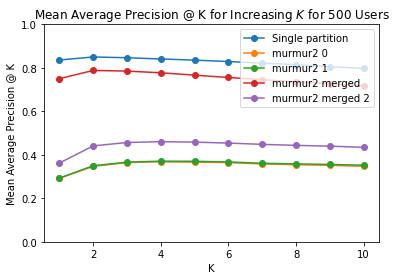

In [23]:
import matplotlib.pyplot as plt

plot = draw_plot(mapk_df, plt)
plot.savefig(output_diagram)

In [61]:
# # formatted_mapk_df = mapk_df.pivot(index=['k'], columns=['hash_function', 'partition'], values=['map'])
# formatted_mapk_df.to_csv(output_map_at_k, index=True)
mapk_df = mapk_df.reset_index(drop=True)
mapk_df.to_csv(output_map_at_k, index=True)